In [1]:
from scipy.io import loadmat,savemat
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import autograd.numpy as np
from mrmgp.mrmgp import MRMGP
import pickle
from copy import deepcopy
import time

/Users/weihanli/opt/anaconda3/envs/julia/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
v1 = loadmat("./data/session_143_stimulus_1.mat")["v1"]
v2 = loadmat("./data/session_143_stimulus_1.mat")["v2"]

v1 = np.sqrt(v1)
v2 = np.sqrt(v2)

total_trials = 100
y = np.concatenate((v1, v2), axis=0)[:,:, np.random.choice(np.arange(v1.shape[2]), size=total_trials, replace=False)]

ys = []
train_trials = 50
train_index = np.random.choice(np.arange(y.shape[2]), size=train_trials, replace=False)
test_index = np.delete(np.arange(y.shape[2]), train_index)
for i in train_index:
    ys.append(y[:, :, i].T)

In [3]:
# hyper parameters
num_groups = 2 # the number of brain regions
K = 2 # the number of states in across-region latent variables
num_derivative = 4 # the number of derivatives (2k) in Eq.7, if num_derivative is 4, then means k=2, a 2 order system in Eq.8 
ydims = [v1.shape[0], v2.shape[0]] # the number of data dimensions
x_across = 2 # the number of across-region latent variables
x_within = np.array([2, 2]) # the number of within-region latent variables

model = MRMGP(
    N = np.sum(ydims),
    K = K,
    num_derivative=num_derivative,
    x_across=x_across,
    x_within=x_within,
    num_groups=num_groups,
    num_times=y.shape[1],
    ydims = ydims
)

In [4]:
elbos, posterior = model.fit(ys, num_iters=150)

res = {}
res["elbos"] = elbos
res['transitions_params'] = deepcopy(model.transitions.params)
res['dynamics_params'] = deepcopy(model.dynamics.params)
res['emissions_params'] = deepcopy(model.emissions.params)

file_name = time.strftime("%Y%m%d-%H%M%S")
with open('./results/res_' + file_name + '.pkl', 'wb') as w:
    pickle.dump(res, w)

Initialize by fitting pcca


ARHMM Initialization restarts:   0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


ELBO: -261578.1: 100%|██████████| 150/150 [11:06<00:00,  4.44s/it]


In [5]:
color_names = ["windows blue","red","amber","faded green","dusty purple","orange","clay","pink","greyish","mint","cyan","steel blue","forest green",
               "pastel purple","salmon","dark brown"]

colors = sns.xkcd_palette(color_names)
cmap = ListedColormap(colors)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


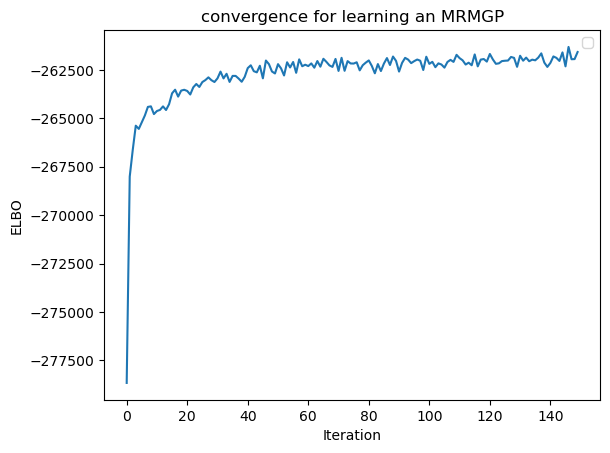

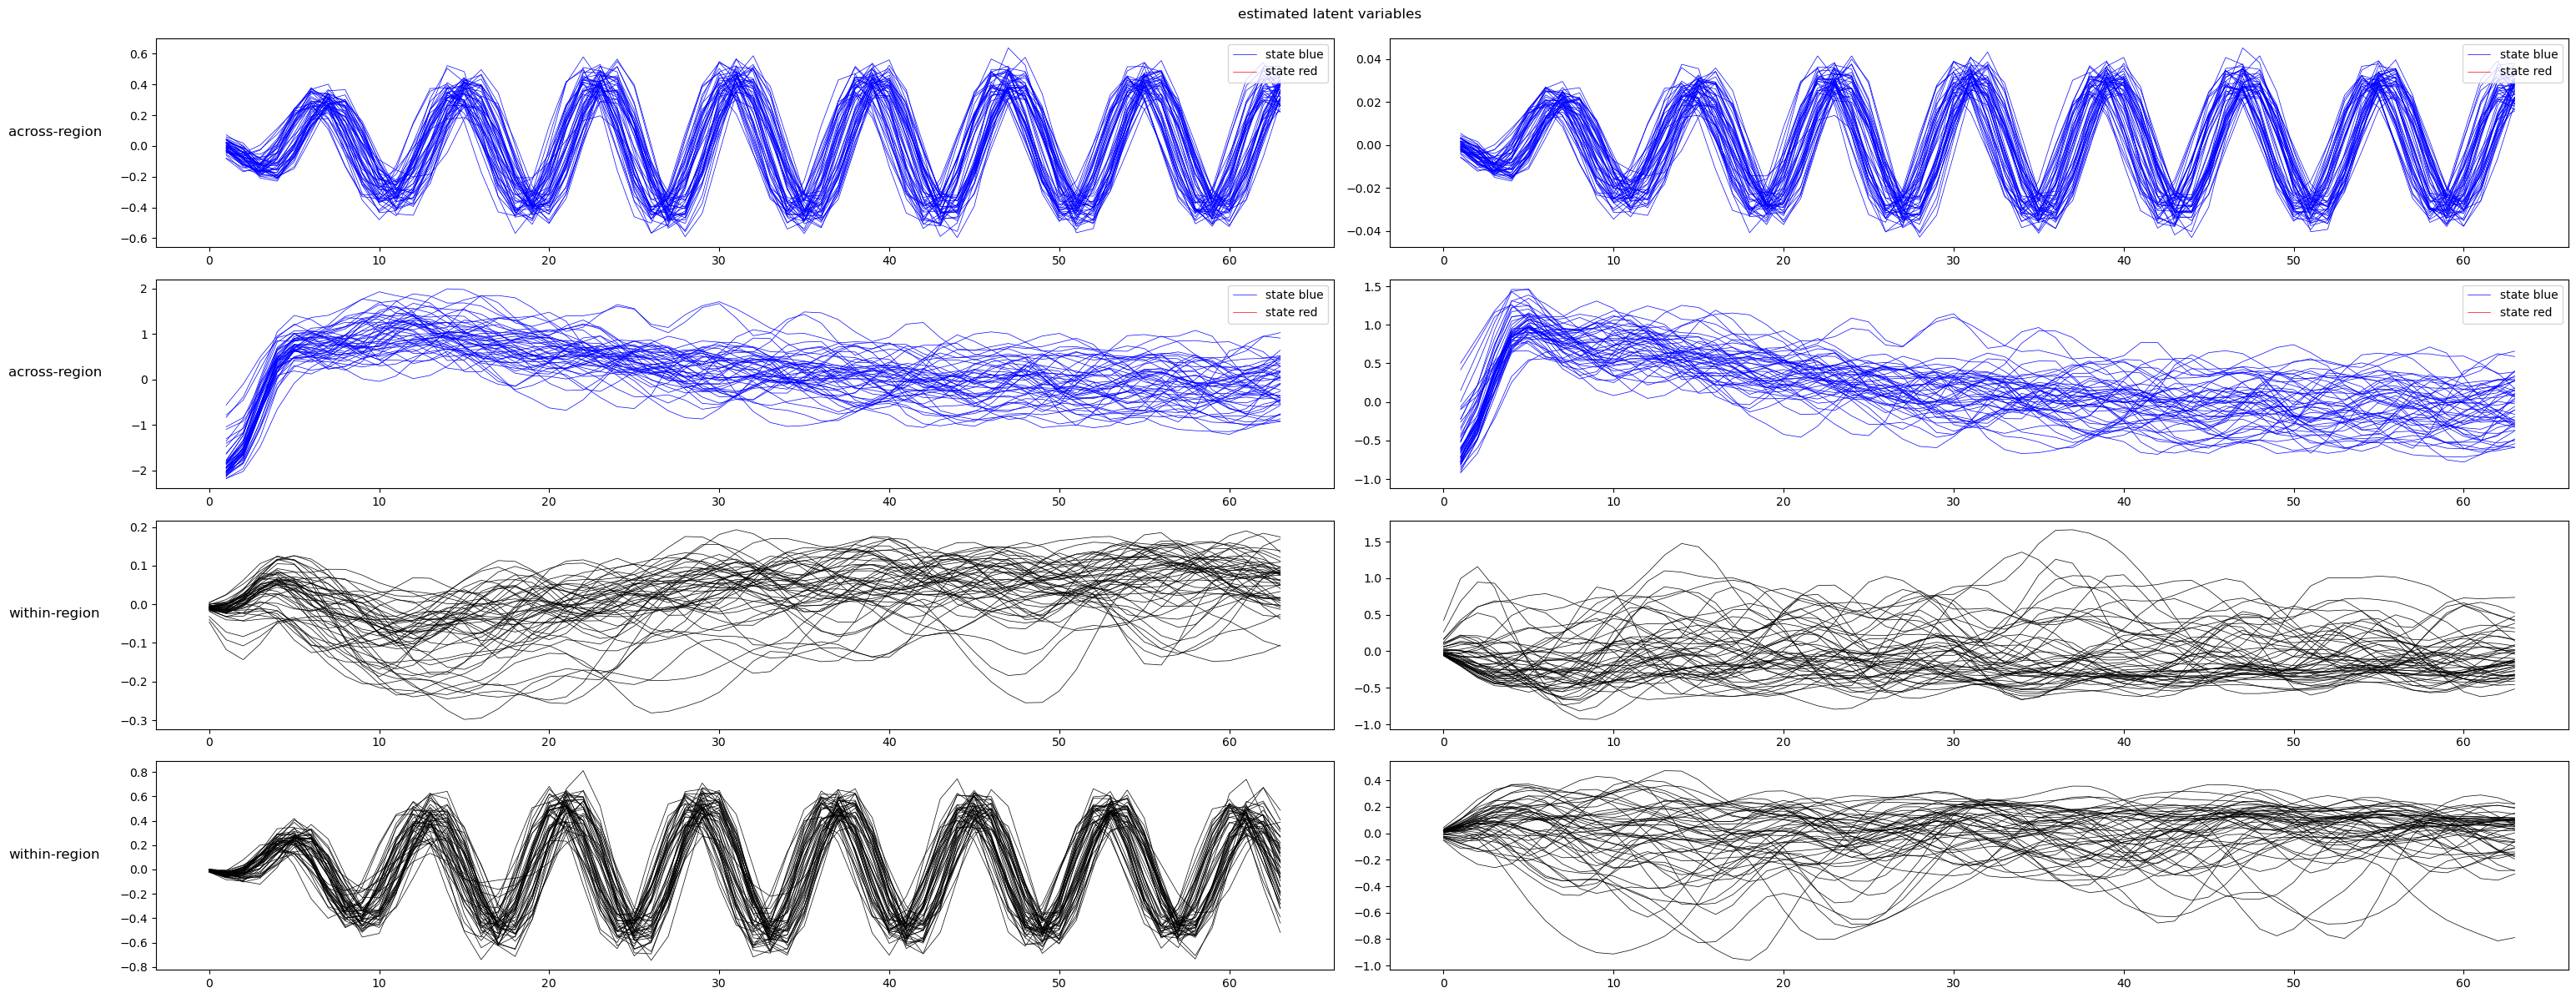

In [6]:
continuous_states = posterior.mean_continuous_states
continuous_states = np.zeros((len(posterior.mean_continuous_states), posterior.mean_continuous_states[0].shape[1], posterior.mean_continuous_states[0].shape[0]))
for t in range(train_trials):
    continuous_states[t,:,:] = posterior.mean_continuous_states[t].T

# plot elbo and estimated state-dependent latent variables
plt.figure()
plt.plot(elbos[1:])
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.title("convergence for learning an MRMGP")

# get the zero-order derivative latent variables
num_derivatives = np.array([num_derivative, num_derivative])
num_dims = np.ceil(num_derivatives/2).astype(np.int32)
x_est = np.zeros((train_trials, num_groups * x_across + sum(x_within), continuous_states.shape[2]))
for i in range(num_groups * x_across + sum(x_within)):
    if i < x_across:
        num_dim = num_dims[0]
        begin_index = i*num_dim
        end_index = (i+1)*num_dim
    elif x_across <= i < x_across + x_within[0]:
        num_dim = num_dims[1]
        begin_index = x_across*num_dims[0] + (i-x_across)*num_dims[1]
        end_index = x_across*num_dims[0] + (i-x_across + 1)*num_dims[1]
    elif x_across + x_within[0] <= i < num_groups * x_across + x_within[0]:
        num_dim = num_dims[0]
        begin_index = x_across*num_dims[0]+x_within[0]*num_dims[1] + (i-x_across-x_within[0])*num_dims[0]
        end_index = x_across*num_dims[0]+x_within[0]*num_dims[1] + (i-x_across-x_within[0]+1)*num_dims[0]
    else:
        num_dim = num_dims[1]
        begin_index = num_groups*x_across*num_dims[0]+x_within[0]*num_dims[1] + (i-num_groups*x_across-x_within[0])*num_dims[1]
        end_index = num_groups*x_across*num_dims[0]+x_within[0]*num_dims[1] + (i-num_groups*x_across-x_within[0]+1)*num_dims[1]
    H_i = np.zeros((1, num_dim))
    H_i[0, 0] = 1
    x_est[:, i,:] = continuous_states[:, begin_index, :]

num_dim_each = x_across + x_within[0]

# scale the latent variables by the variance of emission matrix
C = model.emissions.Cs[0,:,:]
vars = np.zeros((2*num_dim_each, ))
C_a_1 = C[0:ydims[0], 0:x_across]
C_w_1 = C[0:ydims[0], x_across:num_dim_each]
C_a_2 = C[ydims[0]:, num_dim_each:num_dim_each+x_across]
C_w_2 = C[ydims[0]:, num_dim_each+x_across:num_dim_each*2]
Cvars_1 = np.square(np.linalg.norm(C[0:ydims[0], 0:num_dim_each], axis=0))
Cvars_2 = np.square(np.linalg.norm(C[ydims[0]:, num_dim_each:num_dim_each * 2], axis=0))
denom_1 = np.trace(C_a_1 @ C_a_1.T + C_w_1 @ C_w_1.T )
vars[0:num_dim_each] = Cvars_1 / denom_1
denom_2 = np.trace(C_a_2 @ C_a_2.T + C_w_2 @ C_w_2.T )
vars[num_dim_each:] = Cvars_2 / denom_2

scaled_xsm = np.empty_like(x_est)
for i in range(num_dim_each*2):
    scaled_xsm[:,i,:] = vars[i] * x_est[:,i,:]

title_str = ["across-region", "across-region", "within-region", "within-region"]
num_plot_trials = 50
num_dim_each_plot = 2 if num_dim_each == 1 else num_dim_each
xt = np.arange(0, scaled_xsm.shape[2])
fig, axs = plt.subplots(num_dim_each_plot, 2,figsize=(30, 3*num_dim_each_plot))
for i in range(0, num_plot_trials):
    z_est = model.most_likely_states(posterior.mean_continuous_states[i], ys[i])
    blue_times = np.where(z_est == 0)[0]
    red_times = np.where(z_est == 1)[0]
    for j in range(num_dim_each):
        if j < x_across:
            axs[j, 0].plot(xt[blue_times], scaled_xsm[i, j, blue_times], color='b',lw=0.5,label="state blue")
            axs[j, 0].plot(xt[red_times], scaled_xsm[i, j, red_times], color='r',lw=0.5,label="state red")
            axs[j, 1].plot(xt[blue_times], scaled_xsm[i, j + num_dim_each, blue_times], color='b',lw=0.5,label="state blue")
            axs[j, 1].plot(xt[red_times], scaled_xsm[i, j + num_dim_each, red_times], color='r',lw=0.5,label="state red")
            if i == 0:
                axs[j, 0].legend(loc=1)
                axs[j, 1].legend(loc=1)
        else:
            axs[j, 0].plot(xt, scaled_xsm[i, j, :], color='k',lw=0.5)
            axs[j, 1].plot(scaled_xsm[i, j + num_dim_each, :], color='k',lw=0.5)
        axs[j, 0].set_title(title_str[j], loc="left", y=0.5, x=-0.125)

plt.suptitle("estimated latent variables", va="bottom")
plt.tight_layout()

In [7]:
# print the estimated parameters
delays, mus, sigma_across, mus_within ,sigma_within = model.dynamics.params
mus = np.exp(mus)
mus_within = np.exp(mus_within)
sigma_across = np.exp(sigma_across)
sigma_within = np.exp(sigma_within)

# delays and frequencies for two across-region latent variables in blue and red states
# positive delays means v1->v2, and negative delays means v2->v1
print("Delays state blue: ", delays[0,:], " (bins)") # blue-state delays for two across-region latent variables
print("Delays state red: ", delays[1,:],  " (bins)") # red-state delays for two across-region latent variables
print("Across Frequencies state blue: ", mus[0,:], " (rad/s)") # blue-state frequencies for two across-region latent variables
print("Across Frequencies state red: ", mus[1,:], " (rad/s)") # red-state frequencies for two across-region latent variables

Delays state blue:  [ 0.02761482 -0.11077801]  (bins)
Delays state red:  [ 0.03360436 -0.79743176]  (bins)
Across Frequencies state blue:  [0.77940173 0.13795989]  (rad/s)
Across Frequencies state red:  [0.74704321 0.54721098]  (rad/s)


In [ ]:
from sklearn.metrics import r2_score

# evaluate the model on test data with a held-in/held out neuron strategy, see Metrics in Section 5.
avg_r2s = []
for k in range(5):
    # y_train = y[:, :, train_index]
    v1_neuron_held_out = np.sort(np.random.choice(np.arange(0, v1.shape[0]), size=int(np.ceil(v1.shape[0] * 0.25)), replace=False))
    v1_neuron_held_in = np.delete(np.arange(0, v1.shape[0]), v1_neuron_held_out)
    v2_neuron_held_out = np.sort(np.random.choice(np.arange(0, v2.shape[0]), size=int(np.ceil(v2.shape[0] * 0.25)), replace=False))
    v2_neuron_held_in = np.delete(np.arange(0, v2.shape[0]), v2_neuron_held_out)

    tmp_y_test_held_in = np.concatenate((v1[v1_neuron_held_in, :], v2[v2_neuron_held_in, :]), axis=0)[:, :, test_index]
    tmp_y_test_held_out = np.concatenate((v1[v1_neuron_held_out, :], v2[v2_neuron_held_out, :]), axis=0)[:, :, test_index]

    y_test_held_in = []
    y_test_held_out = []
    for i in range(tmp_y_test_held_in.shape[2]):
        y_test_held_in.append(tmp_y_test_held_in[:, :, i].T)
        y_test_held_out.append(tmp_y_test_held_out[:, :, i].T)

    held_in_index = [v1_neuron_held_in, v2_neuron_held_in]
    held_out_index = [v1_neuron_held_out, v2_neuron_held_out]

    elbos_test, posterior_test = model.test_inference(y_test_held_in, index=held_in_index)
    avg_r2 = 0.0
    for i in range(len(test_index)):
        true_y_test_held_out = y_test_held_out[i]
        pred_y_test_held_in = model.smooth(posterior_test.mean_inferred_continuous_states[i], data=y_test_held_out[i], index=held_out_index)
        avg_r2 += r2_score(true_y_test_held_out, pred_y_test_held_in)
    avg_r2 = avg_r2 / len(test_index)

    avg_r2s.append(avg_r2)

print("test r2: ", np.mean(avg_r2s), np.std(avg_r2s))

Initialize by fitting pcca


100%|██████████| 1000/1000 [00:00<00:00, 1064.78it/s]


Initialize by fitting pcca


100%|██████████| 1000/1000 [00:01<00:00, 684.87it/s]


Initialize by fitting pcca


100%|██████████| 1000/1000 [00:01<00:00, 667.33it/s]


Initialize by fitting pcca


100%|██████████| 1000/1000 [00:01<00:00, 741.94it/s]


Initialize by fitting pcca


100%|██████████| 1000/1000 [00:00<00:00, 1231.67it/s]


test r2:  0.13129688031787157 0.01302962227422296
